# EDA

## Pubmed Dataset 

In [29]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
pubmed = pyreadr.read_r('data/raw/pubmed.rds')
pubmed_df = list(pubmed.values())[0]
pubmed_df.head()

,PMID,Title,Abstract,Journal,Authors
0,15165820,"Comparative genomic analyses of frog virus 3, ...",Frog virus 3 (FV3) is the type species member ...,Virology,"Wendy G H Tan, Todd J Barkman, V Gregory Chinc..."
1,16912294,Genome of invertebrate iridescent virus type 3...,Iridoviruses (IVs) are classified into five ge...,Journal of virology,"Gustavo Delhon, Edan R Tulman, Claudio L Afons..."
2,11448171,Analysis of the first complete DNA sequence of...,"Chilo iridescent virus (CIV), the type species...",Virology,"N J Jakob, K Müller, U Bahr, G Darai"
3,17239238,Comparative genomic analysis of the family Iri...,Members of the family Iridoviridae can cause s...,Virology journal,"Heather E Eaton, Julie Metcalf, Emily Penny, V..."
4,20633916,"Frog virus 3 ORF 53R, a putative myristoylated...",Although previous work identified 12 complemen...,Virology,"Dexter S Whitley, Kwang Yu, Robert C Sample, A..."


In [31]:
# Find the shape of the dataframe
pubmed_df.shape

(262819, 5)

In [32]:
# Find the column names of the dataframe
pubmed_df.columns.tolist()

['PMID', 'Title', 'Abstract', 'Journal', 'Authors']

In [33]:
pubmed_df.dtypes

PMID         int32
Title       object
Abstract    object
Journal     object
Authors     object
dtype: object

In [34]:
# Find Missing Values
pubmed_df.isnull().sum()

PMID           0
Title          0
Abstract    8607
Journal        0
Authors        0
dtype: int64

In [35]:
p = pubmed_df.copy()

In [36]:
dup2 = p[p.duplicated('PMID', keep=False)].sort_values('PMID')
dup2.shape

(0, 5)

In [37]:
p['Text_Combined'] = p['Title'].fillna('') + '. ' + p['Abstract'].fillna('') 

In [38]:
p['text_length'] = p['Text_Combined'].str.len()
p['title_length'] = p['Title'].fillna('').str.len()
p['abstract_length'] = p['Abstract'].fillna('').str.len()
# Get summary statistics
p['text_length'].describe()

count    262819.000000
mean       1307.105837
std         480.162787
min          10.000000
25%        1033.000000
50%        1332.000000
75%        1623.000000
max        4911.000000
Name: text_length, dtype: float64

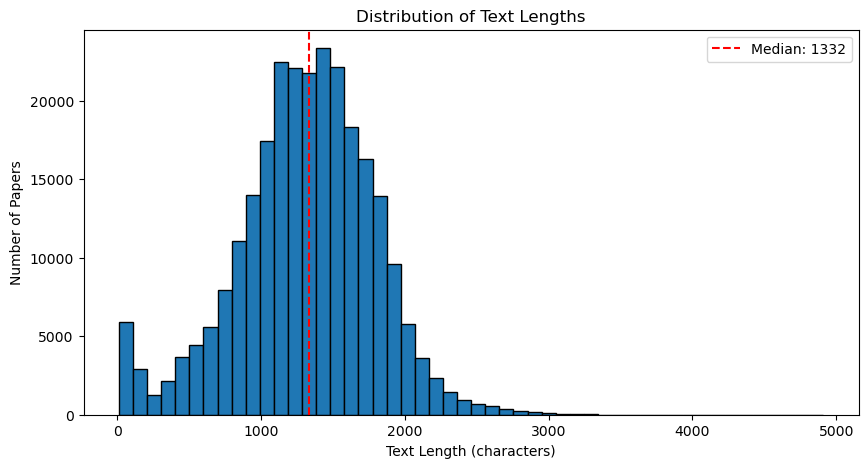

In [39]:
# Visualize the distribution
plt.figure(figsize=(10, 5))
plt.hist(p['text_length'], bins=50, edgecolor='black')
plt.xlabel('Text Length (characters)')
plt.ylabel('Number of Papers')
plt.title('Distribution of Text Lengths')
plt.axvline(p['text_length'].median(), color='red', 
            linestyle='--', label=f"Median: {p['text_length'].median():.0f}")
plt.legend()
plt.show()

## Autoregulatory 

In [40]:
autoreg = pyreadr.read_r('data/raw/autoregulatoryDB.rds')
autoreg_df = list(autoreg.values())[0]
autoreg_df.head()

,AC,OS,RN,RP,RC,RX,RG,RA,RT,RL,Term_in_RP,Term_in_RT,Term_in_RC
0,Q6GZX4,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,
1,Q6GZX3,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,
2,Q197F8,Invertebrate iridescent virus 3 (IIV-3) (Mosqu...,[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=16912294; DOI=10.1128/jvi.00464-06;,NaN,"Delhon G., Tulman E.R., Afonso C.L., Lu Z., Be...","""Genome of invertebrate iridescent virus type ...",J. Virol. 80:8439-8449(2006).,,,
3,Q197F7,Invertebrate iridescent virus 3 (IIV-3) (Mosqu...,[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=16912294; DOI=10.1128/jvi.00464-06;,NaN,"Delhon G., Tulman E.R., Afonso C.L., Lu Z., Be...","""Genome of invertebrate iridescent virus type ...",J. Virol. 80:8439-8449(2006).,,,
4,Q6GZX2,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,


In [41]:
autoreg_df.shape

(1323976, 13)

In [42]:
autoreg_df.columns.tolist()

['AC',
 'OS',
 'RN',
 'RP',
 'RC',
 'RX',
 'RG',
 'RA',
 'RT',
 'RL',
 'Term_in_RP',
 'Term_in_RT',
 'Term_in_RC']

In [43]:
autoreg_df.dtypes

AC            object
OS            object
RN            object
RP            object
RC            object
RX            object
RG            object
RA            object
RT            object
RL            object
Term_in_RP    object
Term_in_RT    object
Term_in_RC    object
dtype: object

In [44]:
a = autoreg_df.copy()

In [45]:
a['PMID'] = a['RX'].str.extract(r'PubMed=(\d+)', expand=False)
a['PMID'] = pd.to_numeric(a['PMID'])

In [46]:
a.isnull().sum()

AC                  0
OS                  0
RN                  0
RP                  0
RC             511667
RX             178720
RG            1210925
RA              68817
RT              56058
RL                  0
Term_in_RP          0
Term_in_RT          0
Term_in_RC          0
PMID           181779
dtype: int64

In [48]:
a['PMID'].head()

0    15165820.0
1    15165820.0
2    16912294.0
3    16912294.0
4    15165820.0
Name: PMID, dtype: float64

In [49]:
dup = a[a.duplicated('PMID', keep=False)].sort_values('PMID')
dup.shape

(1144977, 14)

In [50]:
def merge_terms(row):
    cols = ['Term_in_RP', 'Term_in_RT', 'Term_in_RC']
    terms = []
    for col in cols:
        val = row[col]
        if pd.notna(val):
            split_terms = [t.strip() for t in str(val).split(',') if t.strip()]
            terms.extend(split_terms)
    return ', '.join(sorted(set(terms))) if terms else ''

a['Terms'] = a.apply(merge_terms, axis=1)

In [51]:
labeled = sum((a['Terms'].notna()) & (a['Terms'] != ''))
unlabeled = len(a) - labeled
print(f'Labeled: {labeled}, Unlabeled: {unlabeled}')

Labeled: 1823, Unlabeled: 1322153


In [52]:
labeled/unlabeled * 100

0.13788116806451298

In [60]:
a['has_mechanism'] = a['Terms'].notna() & (a['Terms'] != '')
labeled_df = a[a['has_mechanism'] == True].copy()
unlabeled_df = a[a['has_mechanism'] == False].copy()


In [62]:
print(f"\n✓ Labeled examples: {len(labeled_df)} ({len(labeled_df)/len(a)*100:.2f}%)")
print(f"✓ Unlabeled examples: {len(unlabeled_df)} ({len(unlabeled_df)/len(a)*100:.2f}%)")


✓ Labeled examples: 1823 (0.14%)
✓ Unlabeled examples: 1322153 (99.86%)


In [ ]:
#a['Terms'] = a['Terms'].fillna(False).astype(bool)

## Combined Dataset